### This jupyter notebook employs a fully connective neural network(FC) or its alias artificial neural network (ANN) to learn the mapping between input current configuration between output magnetic field 

In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import torch
if torch.cuda.device_count():
    device = 'cuda'
    print('Good to go')
else:
    device = 'cpu'
    print('Using cpu')

Good to go


In [72]:
from ReadData import ReadCurrentAndField_CNN
import glob
import os 

# TODO zhoujing edit this Data loading 
# print(os.getcwd())
foldername="./Data/"
filepattern = "MagneticField[0-9]*.txt"
train_file_num= 100
#data = ReadFolder(foldername,filepattern)
current,data = ReadCurrentAndField_CNN (foldername,filepattern,train_file_num)

fileList = glob.glob(foldername+filepattern)
position = data[:,0:3,2:18,2:18,2:18]
Bfield = data[:,3:,2:18,2:18,2:18]

# print(fileList)
print(data.shape)
print('current shape', current.shape)
print('Bfield shape', Bfield.shape)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
torch.Size([100, 6, 21, 21, 21])
current shape torch.Size([100, 12])
Bfield shape torch.Size([100, 3, 16, 16, 16])


In [73]:
#data normalization
#find min and max value of input position and Bfield
max_current, max_current_index = torch.max(current, dim=0, keepdim=True)
# print(max_current)
min_current, min_current_index = torch.min(current, dim=0, keepdim=True)
# print(min_current)

max_Bfield, max_Bfield_index = torch.max(Bfield.transpose(0,1).reshape(3,-1), dim=1, keepdim=True)
print(max_Bfield)
min_Bfield, min_Bfield_index = torch.min(Bfield.transpose(0,1).reshape(3,-1), dim=1, keepdim=True)
print(min_Bfield)

dimB = Bfield.shape
dimc = current.shape
print(min_current.shape)
print(min_Bfield.shape)

minB=min_Bfield.expand(3,int(Bfield.numel()/3)).reshape(3,dimB[0],dimB[2],dimB[3],dimB[4]).transpose(0,1)
maxB=max_Bfield.expand(3,int(Bfield.numel()/3)).reshape(3,dimB[0],dimB[2],dimB[3],dimB[4]).transpose(0,1)

ave_current=0.5*(max_current.expand(dimc[0],dimc[1])+min_current.expand(dimc[0],dimc[1]))
diff_current=0.5*(max_current.expand(dimc[0],dimc[1])-min_current.expand(dimc[0],dimc[1]))

current_norm = (current-ave_current)/diff_current
Bfield_norm = (Bfield-(minB+maxB)*0.5)/(0.5*(maxB-minB))

print(min_current.shape)
print(max_current.shape)
print(min_Bfield.shape)
print(max_Bfield.shape)

# torch.save(min_current, "./normalize_data/cnn_min_current.pt")
# torch.save(max_current, "./normalize_data/cnn_max_current.pt")
# torch.save(min_Bfield, "./normalize_data/cnn_min_Bfield.pt")
# torch.save(max_Bfield, "./normalize_data/cnn_max_Bfield.pt")


tensor([[0.0478],
        [0.0409],
        [0.0405]])
tensor([[-0.0439],
        [-0.0424],
        [-0.0421]])
torch.Size([1, 12])
torch.Size([3, 1])
torch.Size([1, 12])
torch.Size([1, 12])
torch.Size([3, 1])
torch.Size([3, 1])


In [74]:
from Neural_network import Generative_net, ResidualEMNSBlock_3d, BigBlock, weight_init, eMNS_Dataset
num_input = 12
output_shape = (3,16,16,16)
SB_args = (64,64,1,4) # (Cin, Cout, num_block)
BB_args = (2,2) # (scale_factor, num_block)
SB_block = ResidualEMNSBlock_3d 
BB_block = BigBlock

Generative_network = Generative_net(SB_args, BB_args, SB_block, BB_block, num_input=num_input, output_shape= output_shape)
print(Generative_network)

print(maxB.shape)
print(maxB[0,:].shape)

Generative_net(
  (proj): Linear(in_features=12, out_features=4096, bias=True)
  (conv3d): Conv3d(64, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (total_net): Sequential(
    (0): Linear(in_features=12, out_features=4096, bias=True)
    (1): Unflatten(dim=1, unflattened_size=(64, 4, 4, 4))
    (2): BigBlock(
      (block): Sequential(
        (0): ResidualEMNSBlock_3d(
          (conv3d): Sequential(
            (0): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (2): LeakyReLU(negative_slope=0.01)
          )
          (block): Sequential(
            (0): Sequential(
              (0): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
              (2): LeakyReLU(negative_slope=0.01)
            )
         

In [75]:
MaxB=maxB.cuda(0)
MinB=minB.cuda(0)
print(MaxB.device)
print(MinB.device)

cuda:0
cuda:0


In [79]:
from Neural_network import Generative_net, ResidualEMNSBlock_3d, BigBlock, weight_init, eMNS_Dataset
from Training_loop import train_part_GM,get_mean_of_dataloader
from tqdm import tqdm

batch_size = 128
# construct dataset
dataset = eMNS_Dataset(
    train_x=current_norm,
    train_y=Bfield_norm
)
###############################################
# Config the neural network
###############################################
num_input = 12
output_shape = (3,16,16,16)
SB_args = (64,64,1,12) # (Cin, Cout, num_repeat, num_block)
BB_args = (2,2) # (scale_factor, num_block)
SB_block = ResidualEMNSBlock_3d 
BB_block = BigBlock
DF = False # whether using divergence free model

Generative_network = Generative_net(SB_args, BB_args, SB_block, BB_block, num_input=num_input, output_shape= output_shape)
epochs = 1000
learning_rate_decay = .5
learning_rates = [1e-3]
RMSE_lr = []
schedule = []
linear_lr = False
weight_decays = [0]

train_percents = np.arange(1.0,1.01,0.1)
RMSE_history_end = np.zeros(len(train_percents))
RMSE_val_history_end = np.zeros(len(train_percents))
loss_history_end = np.zeros(len(train_percents))
iter_history_end = np.zeros(len(train_percents))
mse_history_end = np.zeros(len(train_percents))
mse_val_history_end = np.zeros(len(train_percents))
train_stop_epoch = np.zeros(len(train_percents))

################################################
# Train the neural network
################################################
index=0
for train_percent in train_percents:
    epoch_stop = 0
    print('train_percent',train_percent)
    for learning_rate in tqdm(learning_rates):
        for weight_decay in weight_decays:

            # split the dataset to train, validation, test
            train_set, valid_set = torch.utils.data.random_split(dataset, [0.9,0.1])

            #Using Dataloader for batch train
            train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,shuffle=True)
            valid_loader = torch.utils.data.DataLoader(dataset=valid_set,batch_size=batch_size,shuffle=True)

            get_mean_of_dataloader(valid_loader,model=Generative_network,device=device)
            print("----------------------------")
            
            print("----------------------------")
            # test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,shuffle=True)

            Generative_network.apply(weight_init)
            optimizer = torch.optim.Adam([{'params':Generative_network.parameters()}], lr=learning_rate, weight_decay= weight_decay, betas=(0.5,0.99))
            RMSE_history, RMSE_val_history, loss_history, iter_history, mse_history, mse_val_history,epoch_stop,Rsquare= train_part_GM(
                model=Generative_network, optimizer=optimizer, train_loader=train_loader, valid_loader=valid_loader, epochs=epochs, 
                learning_rate_decay=learning_rate_decay, schedule=schedule, weight_decay=weight_decay, DF=DF,verbose=False, device=device, maxB=MaxB[0,:], minB=MinB[0,:],
                lr_max=learning_rate, lr_min=1e-7,max_epoch=epochs, linear_lr=linear_lr)
        
        RMSE_lr.append(RMSE_val_history[epoch_stop].item())
    
    #save RMSE and loss after early stopping
    RMSE_history_end[index] = RMSE_history[epoch_stop]
    RMSE_val_history_end[index]= RMSE_val_history[epoch_stop]
    loss_history_end[index] = loss_history[epoch_stop]
    iter_history_end[index] = iter_history[epoch_stop]
    mse_history_end[index] = mse_history[epoch_stop]
    mse_val_history_end[index] = mse_val_history[epoch_stop]
    index=index+1
    print('training stop at epoch:',epoch_stop)
    print('training stop at epoch:',Rsquare)

train_percent 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

----------------------------
----------------------------
Epoch 0, Iteration 1, loss = 0.7882
Got rmse 0.016060128808021545
Got rmse 0.015818558633327484

Epoch 1, Iteration 2, loss = 0.6298
Got rmse 0.015092510730028152
Got rmse 0.014861883595585823

Epoch 2, Iteration 3, loss = 0.6363
Got rmse 0.014705120585858822
Got rmse 0.014750059694051743

Epoch 3, Iteration 4, loss = 0.5173
Got rmse 0.013856598176062107
Got rmse 0.016757603734731674

Epoch 4, Iteration 5, loss = 0.4410
Got rmse 0.013196432963013649
Got rmse 0.027580806985497475

Epoch 5, Iteration 6, loss = 0.4245
Got rmse 0.012790724635124207
Got rmse 0.015353132039308548

Epoch 6, Iteration 7, loss = 0.3646
Got rmse 0.012546361424028873
Got rmse 0.0171616580337286

Epoch 7, Iteration 8, loss = 0.3495
Got rmse 0.01208425685763359
Got rmse 0.03151779994368553

Epoch 8, Iteration 9, loss = 0.3684
Got rmse 0.012097610160708427
Got rmse 0.014779913239181042

Epoch 9, Iteration 10, loss = 0.3362
Got rmse 0.011766960844397545
Got rm

100%|██████████| 1/1 [01:02<00:00, 62.19s/it]

Epoch 998, Iteration 999, loss = 0.0286
Got rmse 0.012214528396725655
Got rmse 0.010662198998034

Epoch 999, Iteration 1000, loss = 0.0286
Got rmse 0.01221452746540308
Got rmse 0.010662198998034

training stop at epoch: 999
training stop at epoch: tensor(0.8752, device='cuda:0')


In [14]:
torch.save(Generative_network, 'EMS_CNN.pt')	# 这里会存储迄今最优模型的参数

[0.03780081495642662, 0.0373227521777153, 0.03722217306494713, 0.03545895591378212, 0.031836431473493576, 0.026449138298630714, 0.02230115607380867, 0.019979428499937057, 0.019627626985311508, 0.018998537212610245, 0.01804850436747074, 0.018972059711813927, 0.018569160252809525, 0.01817130669951439, 0.018656747415661812, 0.01871245913207531, 0.019502654671669006, 0.017997365444898605, 0.018794024363160133, 0.01878654956817627, 0.017759814858436584, 0.01885971799492836, 0.018870560452342033, 0.01835472323000431, 0.017911942675709724, 0.018663037568330765, 0.01792033575475216, 0.01801496557891369, 0.018483366817235947, 0.018193582072854042, 0.018101923167705536, 0.018229518085718155, 0.017712272703647614, 0.018491482362151146, 0.01853139139711857, 0.01829950325191021, 0.017500082030892372, 0.019129395484924316, 0.01774345524609089, 0.01997193694114685, 0.018548591062426567, 0.018683653324842453, 0.01831737719476223, 0.018148433417081833, 0.017598368227481842, 0.018085287883877754, 0.0185

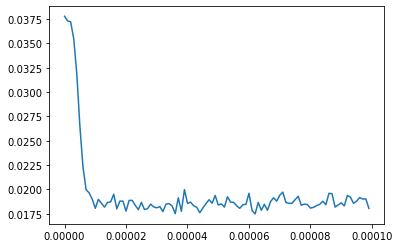

In [16]:
print(RMSE_lr)
print(learning_rates)
print(RMSE_lr[9],learning_rates[9])
import matplotlib.pyplot as plt 
plt.plot(learning_rates,RMSE_lr)

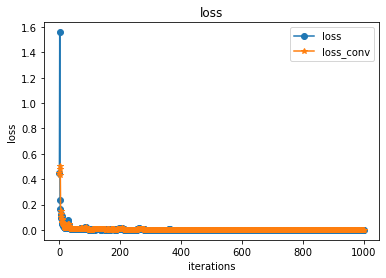

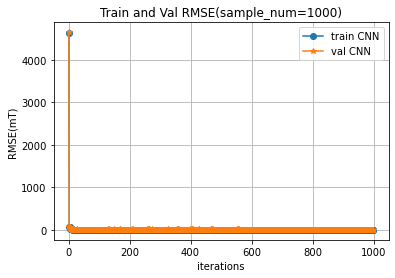

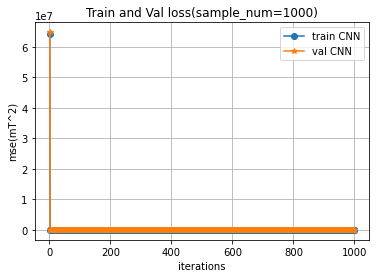

In [71]:
import matplotlib.pyplot as plt
import numpy as np
ave_site = 5
ave_kernel = 1/ave_site*np.ones(ave_site)
loss_history_conv = np.convolve(loss_history.numpy(),ave_kernel,'same')


plt.title('loss')
plt.plot(iter_history,loss_history,'-o')
plt.plot(iter_history,loss_history_conv,'-*')
plt.legend(['loss','loss_conv'])
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()

plt.title('Train and Val RMSE(sample_num=1000)')
plt.plot(iter_history[0:epoch_stop],RMSE_history[0:epoch_stop]*1000,'-o')
plt.plot(iter_history[0:epoch_stop],RMSE_val_history[0:epoch_stop]*1000,'-*')
# plt.plot(2e-5*np.arange(epoch_stop),RMSE_history[0:epoch_stop]*1000,'-o')
# plt.plot(2e-5*np.arange(epoch_stop),RMSE_val_history[0:epoch_stop]*1000,'-*')
# plt.ylim([15,20])
plt.legend(['train CNN','val CNN'])
plt.xlabel('iterations')
plt.ylabel('RMSE(mT)')
plt.grid()
plt.show()

plt.title('Train and Val loss(sample_num=1000)')
plt.plot(iter_history[0:epoch_stop],mse_history[0:epoch_stop]*1e6,'-o')
plt.plot(iter_history[0:epoch_stop],mse_val_history[0:epoch_stop]*1e6,'-*')
plt.legend(['train CNN','val CNN'])
plt.xlabel('iterations')
plt.ylabel('mse(mT^2)')
plt.grid()
plt.show()

In [9]:
print(epoch_stop)

199


In [10]:
print(position[0:1,:].shape)

torch.Size([1, 3, 16, 16, 16])


In [11]:
import torch 
# a = torch.range(1,48).reshape(3,4,4)
a = torch.randn(3,4,4)
b = a+1
grad_a = torch.gradient(a)
grad_a_x = torch.gradient(a[0])
grad_a_y = torch.gradient(a[1])
grad_a_z = torch.gradient(a[2])
print(len(a))
print(grad_a[2])
print(grad_a_z)
error = torch.sum(grad_a[1] + grad_a[2]) - torch.sum(sum(grad_a_x)+sum(grad_a_y) +sum(grad_a_z))
print(error)
print(a[1].shape)

3
tensor([[[-1.6571, -0.9986,  0.2375,  0.8151],
         [-0.3544, -0.0696, -0.5170, -1.2490],
         [-0.1929, -1.4564, -0.1059,  2.5081],
         [-1.2535,  0.0226,  0.7040,  0.1093]],

        [[ 1.5094,  0.5340, -0.5550, -0.6686],
         [-1.2600,  0.0875,  1.0014,  0.5678],
         [ 1.3482, -0.0981,  0.2601,  2.0647],
         [-0.3355, -0.5372,  0.1027,  0.9443]],

        [[ 0.3019,  0.8362,  0.1438, -1.0828],
         [ 0.2225,  0.5054,  0.2983, -0.1917],
         [ 0.6095,  1.1628,  0.5653, -0.5855],
         [ 0.0375,  0.9949, -0.2599, -2.4720]]])
(tensor([[ 0.3429,  0.2635, -0.3187,  0.5725],
        [ 0.1868,  0.3406,  0.5134,  0.7621],
        [ 0.6319,  0.5394,  1.1214, -0.0188],
        [ 1.2331,  0.6611,  0.8973, -0.9892]]), tensor([[ 0.3019,  0.8362,  0.1438, -1.0828],
        [ 0.2225,  0.5054,  0.2983, -0.1917],
        [ 0.6095,  1.1628,  0.5653, -0.5855],
        [ 0.0375,  0.9949, -0.2599, -2.4720]]))
tensor(9.5367e-07)
torch.Size([4, 4])


In [12]:
print(Generative_net)

<class 'Neural_network.Generative_net'>


In [13]:
from torchviz import make_dot
import torch.nn.functional as F
from Training_loop import grad_loss
x = torch.randn(2,12)
y = Bfield[0:2]
preds = Generative_network(x)
print(preds.shape)
loss =   grad_loss(preds,y)
        # optimizer.zero_grad() #zero out all of gradient
loss.backward()

make_dot(loss, params=dict(Generative_network.named_parameters()))

ModuleNotFoundError: No module named 'torchviz'